# Identifying Tasmanian Tigers using Convolutional Neural Networks

## Introduction

In this Jupyter notebook, I present a deep learning project in which I have developed a Convolutional Neural Network (CNN) to identify the probability of an image containing a Tasmanian Tiger or not. Tasmanian Tigers, also known as thylacines, are extinct carnivorous marsupials that once lived in the wilds of Tasmania, Australia. Despite being declared extinct in the 20th century, there have been many alleged sightings of Tasmanian Tigers, and identifying them from images can help further research and conservation efforts.

The project involved building a CNN using the TensorFlow and Keras libraries, and training the model on a large dataset of images containing Tasmanian Tigers and other animals that could be confused with them, such as dogs and foxes. The trained model achieved a high accuracy rate and was able to accurately identify Tasmanian Tigers from images with a high level of precision.

## Methodology

In this notebook, I provide a step-by-step walkthrough of the project, including some data preprocessing, model building, and training. I also provide a detailed analysis of the results and evaluate the performance of the model. This project is an exciting example of how deep learning techniques can be used to tackle complex problems and could potentially contribute to further research and conservation efforts related to Tasmanian Tigers.

While not all the pre-processing steps are included in this repository, I have included the main functions used for image collection and pre-processing in the directory `image_collection_helper_functions`. These functions helped me to efficiently collect and process a large amount of data and prepare it for use in the training of the CNN model.

For this project, I collected a large dataset of images containing Tasmanian Tigers using a combination of web scraping and computer vision techniques. I used the Python CV (Computer Vision) library to extract screenshots from old footage of the Tasmanian Tiger and collected images from Google Images to build a comprehensive dataset.

To ensure the model could accurately identify Tasmanian Tigers from various types of images, I had to train it using both black and white as well as colored photos. This required careful preprocessing of the data to ensure consistency and minimize any potential bias.




## Experimentation

Throughout the development of this project, a number of experiments were conducted to optimize the performance of the CNN model, including:

- Variations in transfer learning versus no transfer learning
- The use of different EfficientNet models
- Varying numbers of epochs
- Dropout versus no dropout
- Regularization versus no regularization
- Changes in learning rates
- Varying numbers of training images
- Varying data augmentation strategies

Each of these variations was tested to identify the combination of factors that produced the highest accuracy on both validation loss and validation accuracy metrics. Additionally, the model's ability to correctly classify random custom images that it had not seen before was also tested to ensure that it was able to generalize well.

After conducting all of these experiments and analyzing the results, I was able to identify the best combination of factors that achieved the highest levels of accuracy and generalization for the CNN model, including:

- The use of transfer learning
- Using the EfficientNetB0 model
- Training for a total of 11 epochs
- The use of L1 regularization with a factor of 0.001
- An Adam optimiser learning rate of 0.001
- A dataset of ~ 42,000 training images
- The use of data augmentation strategies including rotation, zooming, horizontal flipping, and width/height shift


**Not all experiments are detailed in this notebook (there was too many!), only the final model will be shown.**

In [1]:
# Dependencies

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from visualisation_helper_functions import load_and_prep_image, pred_and_plot, plot_history

In [2]:
# Check Tensorflow version and if using personal NVIDIA 2070 Super GPU

print("Tensorflow version: " + str(tf.__version__))
print(tf.config.list_physical_devices('GPU'))

!nvidia-smi

Tensorflow version: 2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Fri Feb 17 15:06:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   38C    P8     8W / 115W |   1059MiB /  8192MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-------------------

# Image Pre-Processing

As this project focuses on identifying whether an image contains a Tasmanian Tiger or not, it is a binary classification problem. Binary classification problems require the model to assign a label to each input image from one of two possible classes. Therefore, in this project, only two directories are required for the input data, one for images containing Tasmanian Tigers and another for images not containing them.

To organize the data, it is common practice to split the data into training, validation, and test sets. Each set is used for a specific purpose in the training and evaluation of the model. However, regardless of the split, there should be only two directories, one for Tasmanian Tiger images and one for non-Tasmanian Tiger images, in all three sets.

I used a Python Library called "splitfolders" to split into training, validation and test sets.

`import splitfolders
splitfolders.ratio('image_folder', output="output", seed=1337, ratio=(.5, 0.45, 0.05))`

In [3]:
train_dir = "../output/train/"
validation_dir = "../output/val"
test_dir = "../output/test/"

IMG_SIZE = (224, 224)


train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="binary", 
                                                                            batch_size=32)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="binary")


test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="binary")

train_data.class_names

Found 41992 files belonging to 2 classes.
Found 41992 files belonging to 2 classes.
Found 4200 files belonging to 2 classes.


['not_tasmanian_tiger', 'tasmanian_tiger']

# Data Augmentation

Data augmentation is particularly useful when there is limited data available, as it can help to address the problem of overfitting. Overfitting occurs when a model performs well on the training data but fails to generalize to new, unseen data. Data augmentation can help to mitigate this problem by increasing the size and diversity of the training dataset, which in turn can improve the model's ability to generalize to new data.

In the case of this project which involves identifying the probability of an image containing a Tasmanian Tiger, there isn't a large number of available images, so data augmentation can be particularly useful. By applying various image transformations to the existing images, the training dataset can be expanded, making it more representative of the overall variability of the image data. This can help to improve the model's accuracy, particularly when it comes to identifying an never seen before Tasmanian Tiger image!

In [4]:
# Create a keras.Sequential layer so that the augmentation can be produced be performed by the GPU rather than CPU 

data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name ="data_augmentation")



# Building the Model

This TensorFlow model is based on the EfficientNetB0 architecture and uses transfer learning to recognize Tasmanian tigers in images. The base model is frozen (i.e., its weights are not updated during training) so that its pre-learned patterns remain intact. The input to the model is an image tensor with shape (224, 224, 3). The input tensor is first passed through a data augmentation layer to create additional training examples.

The output of the base model is then passed through a convolutional layer with 128 filters and 3x3 kernel size with an L1 kernel regularization term of 0.001. The purpose of this layer is to add additional features to the model to better fit the training data. The output of this layer is then globally average pooled, reducing the spatial dimensions of the tensor and aggregating the most important features into a single feature vector.

Finally, the feature vector is passed through a fully connected dense layer with a sigmoid activation function to produce a probability score for the presence of a Tasmanian tiger in the input image. The model is then created by combining the input and output layers into a single TensorFlow model object. Overall, this model represents a powerful and flexible approach to binary image classification that leverages transfer learning and efficient data augmentation.

In [5]:
# Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

x = data_augmentation(inputs)

# Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(x, training=False)

# Add regularizer layer
tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True, kernel_regularizer =tf.keras.regularizers.l1( l=0.001) )


# Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output activation layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model = tf.keras.Model(inputs, outputs)

In [6]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [7]:
# Fit the model 
history = model.fit(train_data,
                             epochs=11,
                             steps_per_epoch=len(train_data),
                             validation_data=test_data,
                             validation_steps=int(len(test_data)))

Epoch 1/11
1313/1313 [==============================] - 207s 153ms/step - loss: 0.0643 - accuracy: 0.9825 - val_loss: 0.0849 - val_accuracy: 0.9788
Epoch 2/11
1313/1313 [==============================] - 144s 110ms/step - loss: 0.0203 - accuracy: 0.9950 - val_loss: 0.0583 - val_accuracy: 0.9852
Epoch 3/11
1313/1313 [==============================] - 128s 97ms/step - loss: 0.0141 - accuracy: 0.9964 - val_loss: 0.0420 - val_accuracy: 0.9883
Epoch 4/11
1313/1313 [==============================] - 118s 90ms/step - loss: 0.0108 - accuracy: 0.9973 - val_loss: 0.0340 - val_accuracy: 0.9905
Epoch 5/11
1313/1313 [==============================] - 114s 87ms/step - loss: 0.0096 - accuracy: 0.9975 - val_loss: 0.0303 - val_accuracy: 0.9914
Epoch 6/11
1313/1313 [==============================] - 111s 84ms/step - loss: 0.0084 - accuracy: 0.9979 - val_loss: 0.0249 - val_accuracy: 0.9940
Epoch 7/11
1313/1313 [==============================] - 108s 82ms/step - loss: 0.0076 - accuracy: 0.9979 - val_loss:

In [8]:
model.evaluate(test_data)

132/132 [==============================] - 6s 46ms/step - loss: 0.0184 - accuracy: 0.9960


[0.0184071846306324, 0.9959523677825928]

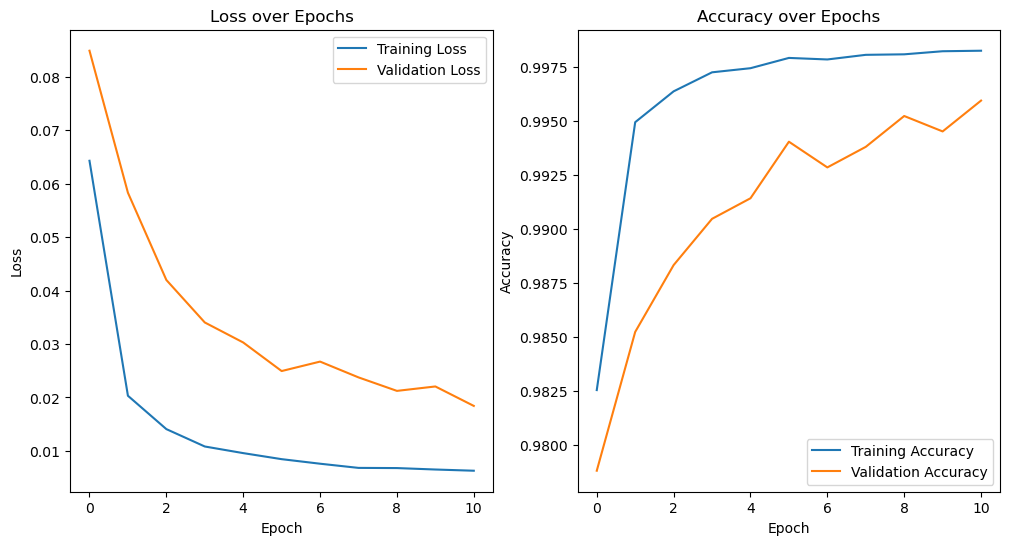

In [9]:
plot_history(history)

# Save the model

In [10]:
model.save("saved_trained_model/assets/saved_trained_model.h5")

# Testing on custom images not seen during training, validation or test

1/1 [==============================] - 1s 1s/step


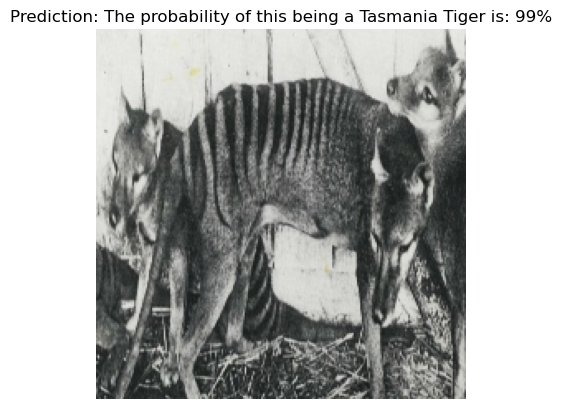

In [11]:
pred_and_plot(model=model,
              filename="random_tests/tas_tigers.jpg")

1/1 [==============================] - 0s 20ms/step


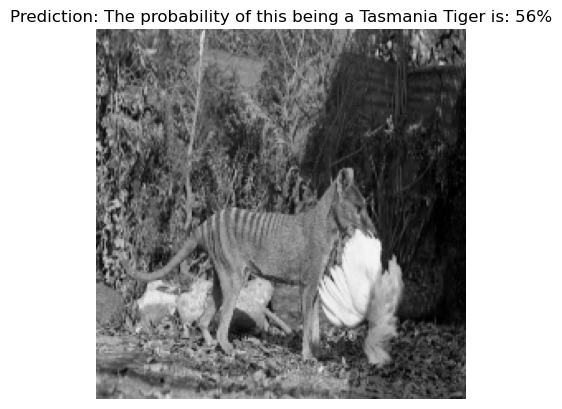

In [31]:
pred_and_plot(model=model,
              filename="random_tests/fake_or_real.jpg")

1/1 [==============================] - 0s 22ms/step


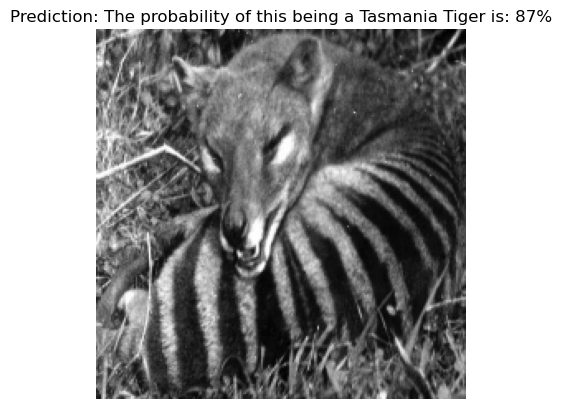

In [28]:
pred_and_plot(model=model,
              filename="random_tests/random6.jpg")

1/1 [==============================] - 0s 21ms/step


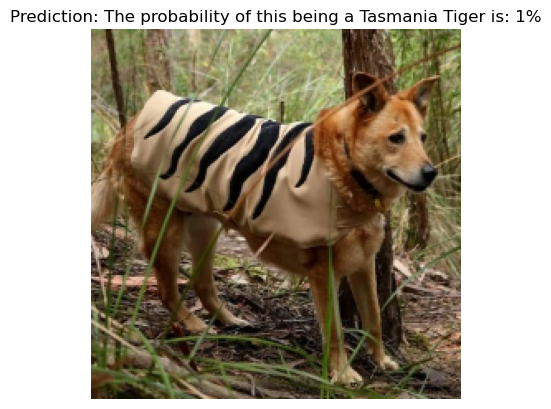

In [25]:
pred_and_plot(model=model,
              filename="random_tests/real_test2.jpg")

1/1 [==============================] - 0s 22ms/step


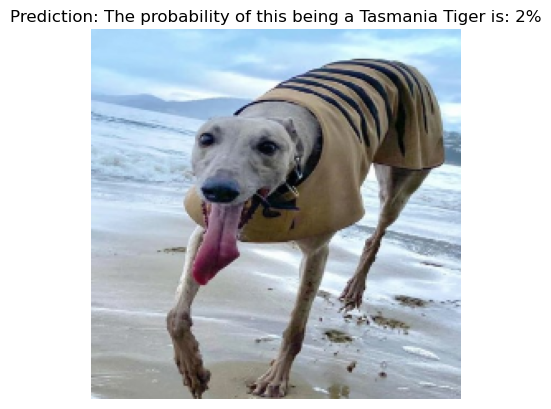

In [27]:
pred_and_plot(model=model,
              filename="random_tests/real_test3.jpg")

1/1 [==============================] - 0s 20ms/step


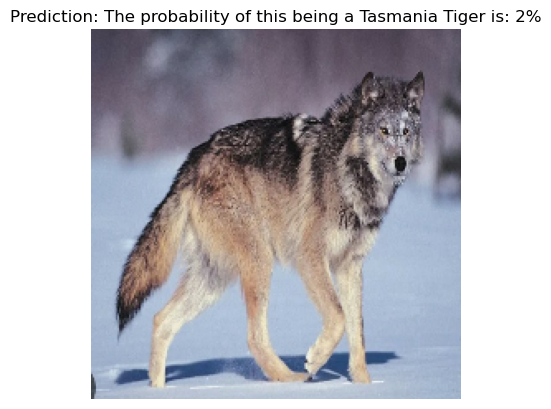

In [30]:
pred_and_plot(model=model,
              filename="random_tests/wolf.jpg")